In [1]:
from astropy.table import Table
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# 1. construct gaia star sample

## Cross-match Gaia DR3 Gold Samples with PS1

In [ ]:
# gold_sample_oba_stars v2 X ps1

SELECT gs.source_id, gs.ra, gs.dec, gs.l, gs.b, 
gs.in_qso_candidates, gs.non_single_star, gs.in_galaxy_candidates, gs.ruwe,
s.vtan_flag, ap.teff_gspphot, ap.lum_flame,
ps.obj_id AS ps_obj_id, ps.ra AS ra_ps, ps.dec AS dec_ps, 
ps.epoch_mean AS ps_epoch_mean, ps.g_mean_psf_mag, ps.g_mean_psf_mag_error, 
ps.r_mean_psf_mag, ps.r_mean_psf_mag_error, ps.i_mean_psf_mag, 
ps.i_mean_psf_mag_error, ps.z_mean_psf_mag, ps.z_mean_psf_mag_error, 
ps.y_mean_psf_mag, ps.y_mean_psf_mag_error, ps.n_detections as ps_n_detections,
xmatch.number_of_mates, xmatch.angular_distance, 
xmatch.clean_panstarrs1_oid, xmatch.number_of_neighbours
FROM gaiadr3.gaia_source AS gs
INNER JOIN gaiadr3.gold_sample_oba_stars AS s USING (source_id)
INNER JOIN gaiadr3.astrophysical_parameters AS ap USING (source_id)
JOIN gaiadr3.panstarrs1_best_neighbour AS xmatch USING (source_id)
JOIN gaiadr2.panstarrs1_original_valid AS ps 
  ON xmatch.original_ext_source_id = ps.obj_id
WHERE gs.ruwe < 1.4 
AND ps.i_mean_psf_mag > 14 
AND ps.z_mean_psf_mag > 0  
AND ps.y_mean_psf_mag > 0   
AND ps.i_mean_psf_mag_error < 0.2171 
AND s.vtan_flag = 0
AND gs.b > -5
AND gs.b < 5
AND gs.teff_gspphot > 7000 
AND gs.classprob_dsc_combmod_star > 0.9 
AND gs.phot_bp_n_obs > 19 
AND gs.phot_rp_n_obs > 19 
AND gs.phot_g_n_obs > 150
AND gs.parallax_over_error > 15
AND gs.ipd_frac_multi_peak < 6 
AND gs.phot_bp_n_blended_transits < 10 
AND (ap.lum_flame_upper-ap.lum_flame_lower)/ap.lum_flame < 0.2
AND (ap.flags_flame = '00' OR ap.flags_flame = '10' OR ap.flags_flame = '20')

In [ ]:
# fgkm star v2 X ps1
# select custom fgkm (select from astrophysical_parameters, criterion mainly fgkm_2)
## do not select from gold_sample_fgkm_stars(fgkm_3 stars, criterion too strict, thus too few)

SELECT gs.source_id, gs.ra, gs.dec, gs.l, gs.b, 
gs.in_qso_candidates, gs.non_single_star, gs.in_galaxy_candidates, gs.ruwe,
ap.teff_gspphot, ap.lum_flame,
ps.obj_id AS ps_obj_id, ps.ra AS ra_ps, ps.dec AS dec_ps, 
ps.g_mean_psf_mag, ps.g_mean_psf_mag_error, 
ps.r_mean_psf_mag, ps.r_mean_psf_mag_error, ps.i_mean_psf_mag, 
ps.i_mean_psf_mag_error, ps.z_mean_psf_mag, ps.z_mean_psf_mag_error, 
ps.y_mean_psf_mag, ps.y_mean_psf_mag_error
FROM gaiadr3.gaia_source AS gs
INNER JOIN gaiadr3.astrophysical_parameters_supp AS aps USING (source_id)
INNER JOIN gaiadr3.astrophysical_parameters AS ap USING (source_id)
JOIN gaiadr3.panstarrs1_best_neighbour AS xmatch USING (source_id)
JOIN gaiadr2.panstarrs1_original_valid AS ps 
  ON xmatch.original_ext_source_id = ps.obj_id
WHERE gs.ruwe < 1.4 
AND gs.teff_gspphot > 2500 
AND gs.teff_gspphot < 7500
AND (gs.libname_gspphot='MARCS' OR gs.libname_gspphot='PHOENIX')
AND ABS(aps.teff_gspphot_marcs - aps.teff_gspphot_phoenix + 65) < 150 
AND gs.distance_gspphot < 1000/(gs.parallax-4*gs.parallax_error) 
AND gs.distance_gspphot > 1/(gs.parallax +4*gs.parallax_error) 
AND ap.mh_gspphot > -0.8 
AND ap.mg_gspphot < 12 
AND gs.phot_bp_n_obs > 19 
AND gs.phot_rp_n_obs > 19 
AND gs.phot_g_n_obs > 150
AND ap.classprob_dsc_combmod_star > 0.9
AND ap.logposterior_gspphot > -4000 
AND gs.teff_gspphot_upper-gs.teff_gspphot_lower < 150
AND gs.parallax_over_error > 15
AND gs.ipd_frac_multi_peak < 6 
AND gs.phot_bp_n_blended_transits < 10 
AND ps.i_mean_psf_mag > 14 
AND ps.z_mean_psf_mag > 0  
AND ps.y_mean_psf_mag > 0   
AND ps.i_mean_psf_mag_error < 0.2171 
AND gs.b > -10
AND gs.b < 10

-- mainly fgkm_2 criterion
-- more strict than fgkm_2
-- limit mag and b




-- 分成四次来跑，每一次只遍历450000000个源
AND random_index BETWEEN 0 AND 450000000
-- AND random_index BETWEEN 450000001 AND 900000000
-- AND random_index BETWEEN 900000001 AND 1350000000
-- AND random_index BETWEEN 1350000001 AND 1811709771

# --------------------- fgkm_2 criterion ----------------------
# |dgb| < 203  difference between Teff versus (GBP− G)0 denoted as dgb
# |dtb| < 0.0267  difference between (G− GRP)0 versus (GBP− G)0 denoted as dtb
# |dteff + 65| < 150
# libname_gspphot = "MARCS" 
# teff_gspphot_upper-teff_gspphot_lower < 150 
# teff_gspphot < 7500
# mh_gspphot > -0.8
# distance_gspphot < 1e3/(parallax-4*parallax_error) 
# distance_gspphot > 1e3/(parallax+4*parallax_error) radius_gspphot < 100
# mg_gspphot < 12
# logposterior_gspphot > -4000 
# classprob_dsc_combmod_star > 0.9
# phot_bp_n_obs > 19
# phot_rp_n_obs > 19
# phot_g_n_obs > 150

In [4]:
fgkm2_1_tb = Table.read('fgkm_2_1-result.fits',character_as_bytes=False)
fgkm2_2_tb = Table.read('fgkm_2_2-result.fits',character_as_bytes=False)
fgkm2_3_tb = Table.read('fgkm_2_3-result.fits',character_as_bytes=False)
fgkm2_4_tb = Table.read('fgkm_2_4-result.fits',character_as_bytes=False)

fgkm2_1 = fgkm2_1_tb.to_pandas()
fgkm2_2 = fgkm2_2_tb.to_pandas()
fgkm2_3 = fgkm2_3_tb.to_pandas()
fgkm2_4 = fgkm2_4_tb.to_pandas()

fgkm2 = pd.concat([fgkm2_1,fgkm2_2,fgkm2_3,fgkm2_4])
fgkm2

,source_id,ra,dec,l,b,in_qso_candidates,non_single_star,in_galaxy_candidates,ruwe,teff_gspphot,...,g_mean_psf_mag,g_mean_psf_mag_error,r_mean_psf_mag,r_mean_psf_mag_error,i_mean_psf_mag,i_mean_psf_mag_error,z_mean_psf_mag,z_mean_psf_mag_error,y_mean_psf_mag,y_mean_psf_mag_error
0,6030025751744438656,256.382269,-28.305384,355.602716,7.650854,False,0,False,0.980180,4372.102539,...,17.607700,0.004469,16.514500,0.003280,15.996400,0.003374,15.7149,0.002631,15.5587,0.003224
1,6030070110124908544,255.165189,-28.798500,354.556812,8.210278,False,0,False,0.976708,6227.741699,...,16.121700,0.005390,15.670600,0.006195,15.473800,0.006804,15.4634,0.020046,15.3511,0.005575
2,6030028667915013504,256.448114,-28.220258,355.706568,7.654840,False,0,False,0.978842,4341.535156,...,16.709900,0.002759,15.547100,0.005792,14.985600,0.002254,14.6887,0.010155,14.5008,0.003187
3,6030028775401524224,256.444174,-28.189970,355.729065,7.675631,False,0,False,1.138768,4233.521973,...,17.825800,0.002641,16.691700,0.002067,16.124001,0.004507,15.8021,0.002505,15.6345,0.004780
4,4264877103065114112,289.752157,1.937463,37.815790,-5.240135,False,0,False,1.074066,5836.338379,...,16.440001,0.002623,15.623600,0.002570,15.182200,0.001366,14.9500,0.002218,14.7931,0.008681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
613746,6030014035071889152,256.776328,-28.335301,355.786062,7.353890,False,0,False,1.020070,4145.146484,...,17.580200,0.005552,16.555099,0.003688,16.049801,0.002334,15.7604,0.000623,15.5870,0.002579
613747,6030014442985038336,256.907084,-28.335861,355.854232,7.260757,False,0,False,1.010769,5259.250977,...,16.731100,0.002166,16.169701,0.004187,15.934800,0.005654,15.7946,0.007882,15.7046,0.004272
613748,6029924631017204864,256.688578,-28.913205,355.270872,7.073405,False,0,False,1.013394,4401.444336,...,17.751600,0.005294,16.675400,0.004075,16.224100,0.005280,15.9734,0.000699,15.8194,0.004792
613749,6030017367966617728,256.750337,-28.278016,355.818955,7.406245,False,0,False,0.966412,5131.306641,...,16.675301,0.005465,16.068100,0.005221,15.793500,0.000674,15.6532,0.007812,15.5741,0.011660


In [5]:
fgkm2.to_csv('fgkm_2.csv')

## then crossmatch with gps and catwise on topcat

In [2]:
gaiadr3fgkm_tb = Table.read('gaiadr3_fgkm2_b5_gpc.fits',character_as_bytes=False)
gaiadr3fgkm = gaiadr3fgkm_tb.to_pandas()

gaiadr3oba_tb = Table.read('gaiadr3_oba_limit_b5_gpc.fits',character_as_bytes=False)
gaiadr3oba = gaiadr3oba_tb.to_pandas()

In [3]:
gaiadr3fgkm.shape, gaiadr3oba.shape

((354762, 93), (52560, 99))

In [63]:
import seaborn as sns

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams["figure.figsize"] = (5,3) # 调整图片尺寸
plt.rcParams["figure.dpi"] = 180  # 提高图片分辨率

In [19]:
! pip install mpl-scatter-density

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 655 kB 1.8 MB/s eta 0:00:01
     |████████████████████████████████| 52 kB 125 kB/s  eta 0:00:01


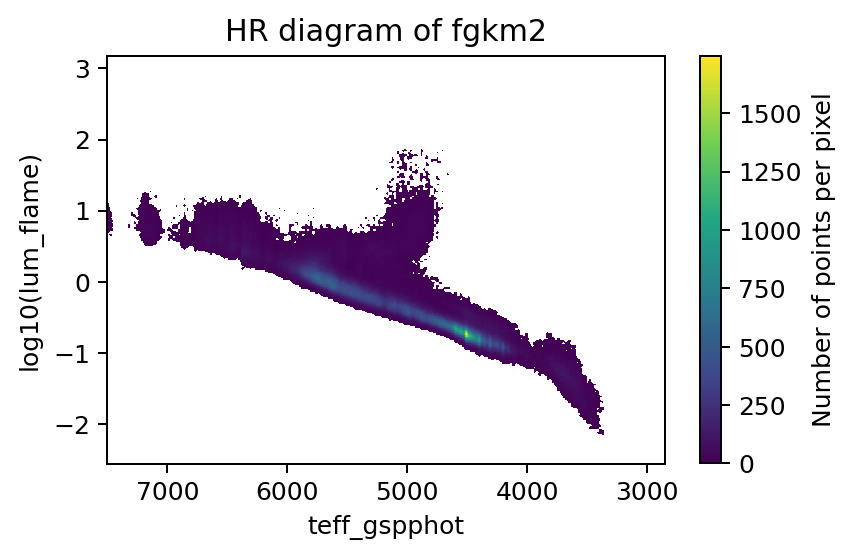

In [64]:
import mpl_scatter_density # adds projection='scatter_density'
from matplotlib.colors import LinearSegmentedColormap

# "Viridis-like" colormap with white background
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, '#440053'),
    (0.2, '#404388'),
    (0.4, '#2a788e'),
    (0.6, '#21a784'),
    (0.8, '#78d151'),
    (1, '#fde624'),
], N=256)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
density = ax.scatter_density(gaiadr3fgkm.teff_gspphot, np.log10(gaiadr3fgkm.lum_flame), cmap=white_viridis)
fig.colorbar(density, label='Number of points per pixel')


ax.invert_xaxis()
plt.xlabel('teff_gspphot')
plt.ylabel('log10(lum_flame)')
plt.title('HR diagram of fgkm2')
plt.show()

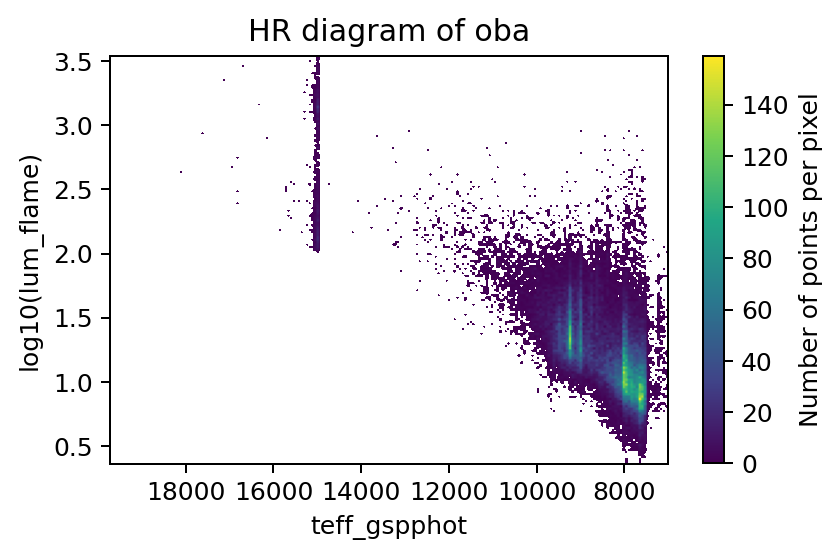

In [65]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
density2 = ax.scatter_density(gaiadr3oba.teff_gspphot, np.log10(gaiadr3oba.lum_flame), cmap=white_viridis)
fig.colorbar(density2, label='Number of points per pixel')


ax.invert_xaxis()
plt.xlabel('teff_gspphot')
plt.ylabel('log10(lum_flame)')
plt.title('HR diagram of oba')
plt.show()

In [5]:
gaiadr3 = pd.concat([gaiadr3fgkm,gaiadr3oba])
gaiadr3

,col1,source_id,ra,dec,l,b,in_qso_candidates,non_single_star,in_galaxy_candidates,ruwe,...,epoch,mergedClass,angDist_x,vtan_flag,ps_epoch_mean,ps_n_detections,number_of_mates,angular_distance,clean_panstarrs1_oid,number_of_neighbours
0,4.0,4264877103065114112,289.752157,1.937463,37.815790,-5.240135,False,0,False,1.074066,...,2007.372925,255,0.144274,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5.0,4264828621469067264,289.825877,1.847460,37.769721,-5.347023,False,0,False,0.993031,...,2007.372925,255,0.148512,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7.0,4264878236936568320,289.632360,1.910495,37.736318,-5.146335,False,0,False,1.021065,...,2007.372925,255,0.331726,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,14.0,4264880539039071616,289.673493,1.966170,37.804956,-5.157138,False,0,False,1.011523,...,2007.372925,255,0.165699,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,19.0,4264838207836647424,290.018356,2.035271,38.026245,-5.431014,False,0,False,1.079056,...,2007.373047,255,0.270892,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52555,NaN,3456380227154682880,87.189164,37.458618,173.031892,4.962649,False,0,False,1.002774,...,2007.817017,255,0.076614,0.0,56179.687500,52.0,0.0,0.006940,1.747437e+09,1.0
52556,NaN,3456394486446001024,86.928042,37.534329,172.860298,4.823287,False,0,False,0.929618,...,2007.817017,255,0.090721,0.0,56094.066406,61.0,0.0,0.003935,1.748715e+09,1.0
52557,NaN,3456394795683637632,86.943342,37.540228,172.861449,4.836728,False,0,False,0.958178,...,2007.817017,255,0.079903,0.0,56060.980469,58.0,0.0,0.003375,1.748815e+09,1.0
52558,NaN,3456396582389995776,87.016540,37.596996,172.842299,4.915625,False,0,False,0.883171,...,2007.817017,255,0.096202,0.0,56118.500000,57.0,0.0,0.002289,1.749776e+09,1.0


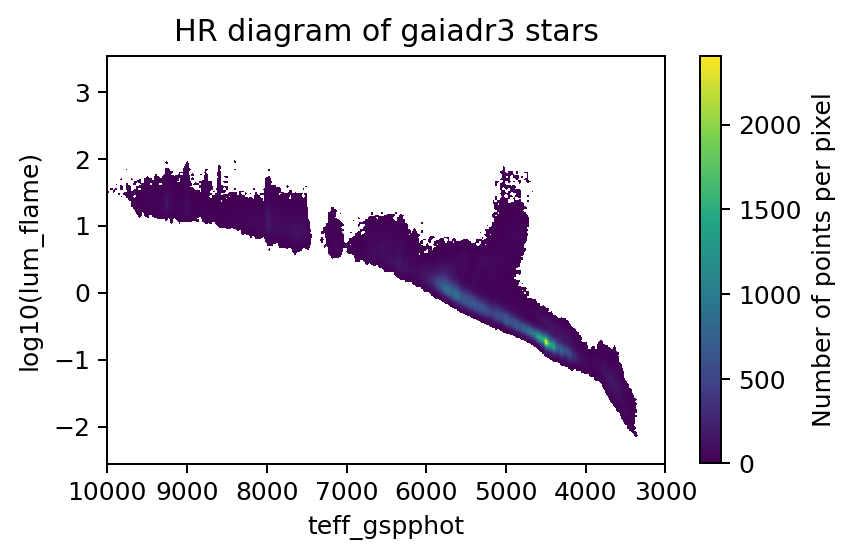

In [68]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
density2 = ax.scatter_density(gaiadr3.teff_gspphot, np.log10(gaiadr3.lum_flame), cmap=white_viridis)
fig.colorbar(density2, label='Number of points per pixel')


ax.invert_xaxis()
plt.xlim(10000,3000,1000)
plt.xlabel('teff_gspphot')
plt.ylabel('log10(lum_flame)')
plt.title('HR diagram of gaiadr3 stars')
plt.show()

In [6]:
gaiadr3 = gaiadr3[gaiadr3.teff_gspphot<14000]
gaiadr3

,col1,source_id,ra,dec,l,b,in_qso_candidates,non_single_star,in_galaxy_candidates,ruwe,...,epoch,mergedClass,angDist_x,vtan_flag,ps_epoch_mean,ps_n_detections,number_of_mates,angular_distance,clean_panstarrs1_oid,number_of_neighbours
0,4.0,4264877103065114112,289.752157,1.937463,37.815790,-5.240135,False,0,False,1.074066,...,2007.372925,255,0.144274,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5.0,4264828621469067264,289.825877,1.847460,37.769721,-5.347023,False,0,False,0.993031,...,2007.372925,255,0.148512,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7.0,4264878236936568320,289.632360,1.910495,37.736318,-5.146335,False,0,False,1.021065,...,2007.372925,255,0.331726,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,14.0,4264880539039071616,289.673493,1.966170,37.804956,-5.157138,False,0,False,1.011523,...,2007.372925,255,0.165699,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,19.0,4264838207836647424,290.018356,2.035271,38.026245,-5.431014,False,0,False,1.079056,...,2007.373047,255,0.270892,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52555,NaN,3456380227154682880,87.189164,37.458618,173.031892,4.962649,False,0,False,1.002774,...,2007.817017,255,0.076614,0.0,56179.687500,52.0,0.0,0.006940,1.747437e+09,1.0
52556,NaN,3456394486446001024,86.928042,37.534329,172.860298,4.823287,False,0,False,0.929618,...,2007.817017,255,0.090721,0.0,56094.066406,61.0,0.0,0.003935,1.748715e+09,1.0
52557,NaN,3456394795683637632,86.943342,37.540228,172.861449,4.836728,False,0,False,0.958178,...,2007.817017,255,0.079903,0.0,56060.980469,58.0,0.0,0.003375,1.748815e+09,1.0
52558,NaN,3456396582389995776,87.016540,37.596996,172.842299,4.915625,False,0,False,0.883171,...,2007.817017,255,0.096202,0.0,56118.500000,57.0,0.0,0.002289,1.749776e+09,1.0


In [7]:
gaiadr3.in_qso_candidates.value_counts()

False    406428
True          3
Name: in_qso_candidates, dtype: int64

In [8]:
gaiadr3.in_galaxy_candidates.value_counts()

False    406431
Name: in_galaxy_candidates, dtype: int64

In [9]:
gaiadr3_drop = gaiadr3.drop_duplicates(['source_id'])  # no duplicate source

In [52]:
gaiadr3_filtered=gaiadr3_drop[~(gaiadr3_drop.in_qso_candidates|gaiadr3_drop.in_galaxy_candidates)]
gaiadr3_filtered

,col1,source_id,ra,dec,l,b,in_qso_candidates,non_single_star,in_galaxy_candidates,ruwe,...,epoch,mergedClass,angDist_x,vtan_flag,ps_epoch_mean,ps_n_detections,number_of_mates,angular_distance,clean_panstarrs1_oid,number_of_neighbours
0,4.0,4264877103065114112,289.752157,1.937463,37.815790,-5.240135,False,0,False,1.074066,...,2007.372925,255,0.144274,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5.0,4264828621469067264,289.825877,1.847460,37.769721,-5.347023,False,0,False,0.993031,...,2007.372925,255,0.148512,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7.0,4264878236936568320,289.632360,1.910495,37.736318,-5.146335,False,0,False,1.021065,...,2007.372925,255,0.331726,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,14.0,4264880539039071616,289.673493,1.966170,37.804956,-5.157138,False,0,False,1.011523,...,2007.372925,255,0.165699,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,19.0,4264838207836647424,290.018356,2.035271,38.026245,-5.431014,False,0,False,1.079056,...,2007.373047,255,0.270892,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52555,NaN,3456380227154682880,87.189164,37.458618,173.031892,4.962649,False,0,False,1.002774,...,2007.817017,255,0.076614,0.0,56179.687500,52.0,0.0,0.006940,1.747437e+09,1.0
52556,NaN,3456394486446001024,86.928042,37.534329,172.860298,4.823287,False,0,False,0.929618,...,2007.817017,255,0.090721,0.0,56094.066406,61.0,0.0,0.003935,1.748715e+09,1.0
52557,NaN,3456394795683637632,86.943342,37.540228,172.861449,4.836728,False,0,False,0.958178,...,2007.817017,255,0.079903,0.0,56060.980469,58.0,0.0,0.003375,1.748815e+09,1.0
52558,NaN,3456396582389995776,87.016540,37.596996,172.842299,4.915625,False,0,False,0.883171,...,2007.817017,255,0.096202,0.0,56118.500000,57.0,0.0,0.002289,1.749776e+09,1.0


In [53]:
gaiadr3_filtered.columns

Index(['col1', 'source_id', 'ra', 'dec', 'l', 'b', 'in_qso_candidates',
       'non_single_star', 'in_galaxy_candidates', 'ruwe', 'teff_gspphot',
       'lum_flame', 'ps_obj_id', 'ra_ps', 'dec_ps', 'g_mean_psf_mag',
       'g_mean_psf_mag_error', 'r_mean_psf_mag', 'r_mean_psf_mag_error',
       'i_mean_psf_mag', 'i_mean_psf_mag_error', 'z_mean_psf_mag',
       'z_mean_psf_mag_error', 'y_mean_psf_mag', 'y_mean_psf_mag_error',
       'objID', 'RAdeg', 'DEdeg', 'errHalfMaj', 'errHalfMin', 'errPosAng',
       'Name', 'e_RAdeg', 'e_DEdeg', 'ePos', 'nW1', 'mW1', 'nW2', 'mW2', 'MJD',
       'RAPMdeg', 'DEPMdeg', 'e_RAPMdeg', 'e_DEPMdeg', 'ePosPM', 'pmRA',
       'pmDE', 'e_pmRA', 'e_pmDE', 'snrW1pm', 'snrW2pm', 'FW1pm', 'e_FW1pm',
       'FW2pm', 'e_FW2pm', 'W1mproPM', 'e_W1mproPM', 'W2mproPM', 'e_W2mproPM',
       'pmQual', 'Dist', 'chi2pmRA', 'chi2pmDE', 'ka', 'k1', 'k2', 'km',
       'plx1', 'e_plx1', 'plx2', 'e_plx2', 'Sep', 'ccf', 'abfl', 'angDist',
       'JName', 'ra_x', 'dec_x', 'jApe

In [54]:
gaiadr3_filtered.rename(columns={'g_mean_psf_mag':'gp','r_mean_psf_mag':'rp','i_mean_psf_mag':'ip',
                                   'z_mean_psf_mag':'zp','y_mean_psf_mag':'yp',
                         'jAperMag3':'jap','hAperMag3':'hap','k_1AperMag3':'kap',
                        'W1mproPM':'w1vega','W2mproPM':'w2vega'},inplace=True)

gaiadr3_filtered.eval('w1ab=w1vega+2.699',inplace=True)
gaiadr3_filtered.eval('w2ab=w2vega+3.339',inplace=True)
gaiadr3_filtered.eval('jab=jap+0.938',inplace=True)
gaiadr3_filtered.eval('hab=hap+1.379',inplace=True)
gaiadr3_filtered.eval('kab=kap+1.900',inplace=True)

                            
# gaiadr3_good = gaiadr3_filtered.query("ip <= 23.1\
#             and zp <= 22.3\
#             and yp <= 21.3\
#             and jap<= 19.8")

gaiadr3_filtered.reset_index(inplace=True, drop=True)
gaiadr3_select = gaiadr3_filtered[['source_id', 'ra', 'dec',
                                   'w1ab', 'w2ab', 'gp', 'rp', 'ip', 'zp', 'yp', 'jab', 'hab','kab' ]]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [55]:
gaiadr3_select.to_csv('/cargo/public/catdata/ml_train/gaiadr3star_sample_b5.csv',index=False)

# 2. construct dwarf sample

# 3. construct training sample

In [56]:
mock_gpq = pd.read_csv('/cargo/public/catdata/gpq_nir/output/GoodMockGPQNIR_encap_10.csv')
mock_gal = pd.read_csv('/cargo/public/catdata/galaxy/output/GoodMockGalNIR_encap_5.csv')
gaiadr3_sample = pd.read_csv('/cargo/public/catdata/ml_train/gaiadr3star_sample_b5.csv')
dwarf_sample = pd.read_csv('/cargo/public/catdata/ml_train/dwarf_sample.csv')

In [11]:
# 在机器学习训练的时候限制只用dec>-30的数据集(ps1 trace)

In [57]:
mock_gpq.query('dec>-30').shape,mock_gal.query('dec>-30').shape,gaiadr3_sample.query('dec>-30').shape,dwarf_sample.query('dec>-30').shape

((120891, 88), (111681, 76), (406379, 13), (69994, 12))

In [16]:
mock_gpq.columns 

Index(['source_id', 'ra', 'dec', 'redshift_qsoc', 'snrW1pm', 'snrW2pm',
       'w1vega', 'w2vega', 'gp', 'rp', 'ip', 'zp', 'yp',
       'g_mean_psf_mag_error', 'r_mean_psf_mag_error', 'i_mean_psf_mag_error',
       'z_mean_psf_mag_error', 'y_mean_psf_mag_error', 'yap', 'jap', 'hap',
       'kap', 'yAperMag3Err', 'j_1AperMag3Err', 'hAperMag3Err', 'kAperMag3Err',
       'pmRA_x', 'pmDE', 'e_pmRA', 'e_pmDE', 'l', 'b', 'w1ab', 'w2ab', 'yab',
       'jab', 'hab', 'kab', 'o_ra', 'o_dec', 'o_l', 'o_b', 'o_g', 'o_r', 'o_i',
       'o_z', 'o_y', 'o_yap', 'o_jap', 'o_hap', 'o_kap', 'o_jab', 'o_hab',
       'o_kab', 'o_w1vega', 'o_w2vega', 'o_w1ab', 'o_w2ab', 'o_ebv', 'Z_DR16Q',
       'EBV', 'e_gmag', 'e_rmag', 'e_imag', 'e_zmag', 'e_ymag', 'pmRA_s',
       'pmDE_s', 'e_pmRA_s', 'e_pmDE_s', 'dgp', 'drp', 'dip', 'dzp', 'dyp',
       'dyap', 'djap', 'dhap', 'dkap', 'dyab', 'djab', 'dhab', 'dkab',
       'dw1vega', 'dw2vega', 'dw1ab', 'dw2ab', 'ebv'],
      dtype='object')

In [17]:
mock_gpq_select = mock_gpq[['ra', 'dec',
                             'w1ab', 'w2ab', 'gp', 'rp', 'ip', 'zp', 'yp', 'jab', 'hab','kab']]

In [18]:
mock_gal.columns

Index(['source_id', 'ra', 'dec', 'l', 'b', 'snrW1pm', 'snrW2pm', 'w1vega',
       'w2vega', 'gp', 'rp', 'ip', 'zp', 'yp', 'g_mean_psf_mag_error',
       'r_mean_psf_mag_error', 'i_mean_psf_mag_error', 'z_mean_psf_mag_error',
       'y_mean_psf_mag_error', 'yap', 'jap', 'hap', 'kap', 'yAperMag3Err',
       'j_1AperMag3Err', 'hAperMag3Err', 'kAperMag3Err', 'pmRA_x', 'pmDE',
       'e_pmRA', 'e_pmDE', 'w1ab', 'w2ab', 'yab', 'jab', 'hab', 'kab', 'o_ra',
       'o_dec', 'o_l', 'o_b', 'o_g', 'o_r', 'o_i', 'o_z', 'o_y', 'o_yap',
       'o_jap', 'o_hap', 'o_kap', 'o_jab', 'o_hab', 'o_kab', 'o_w1vega',
       'o_w2vega', 'o_w1ab', 'o_w2ab', 'o_ebv', 'dgp', 'drp', 'dip', 'dzp',
       'dyp', 'dyap', 'djap', 'dhap', 'dkap', 'dyab', 'djab', 'dhab', 'dkab',
       'dw1vega', 'dw2vega', 'dw1ab', 'dw2ab', 'ebv'],
      dtype='object')

In [19]:
mock_gal_select = mock_gal[['ra', 'dec',
                             'w1ab', 'w2ab', 'gp', 'rp', 'ip', 'zp', 'yp', 'jab', 'hab','kab']]

In [21]:
gaiadr3_sample_select = gaiadr3_sample[['ra', 'dec',
                             'w1ab', 'w2ab', 'gp', 'rp', 'ip', 'zp', 'yp', 'jab', 'hab','kab']]

In [23]:
# 添加class一栏

mock_gpq_select['class'] = 'QSO'
mock_gal_select['class'] = 'GALAXY'
gaiadr3_sample_select['class'] = 'STAR'
dwarf_sample['class'] = 'STAR'



<ipython-input-23-b0f0c1c90a28>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mock_gpq_select['class'] = 'QSO'
<ipython-input-23-b0f0c1c90a28>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mock_gal_select['class'] = 'GALAXY'


# 样本的分布

# 三类样本整合到一起

In [24]:
trainingset = pd.concat([mock_gpq_select,mock_gal_select,gaiadr3_sample_select,dwarf_sample])
trainingset

,ra,dec,w1ab,w2ab,gp,rp,ip,zp,yp,jab,hab,kab,class
0,112.336868,-20.381925,18.455769,17.888847,23.339503,22.068447,20.960426,20.560729,20.260287,19.903996,NaN,19.214646,QSO
1,248.753604,-40.519299,18.160292,18.022861,25.153252,23.330411,22.265978,21.419235,20.681469,19.854404,19.125551,18.578343,QSO
2,86.159131,36.315607,16.557036,16.112692,23.459801,21.685209,20.776193,19.849645,19.637200,18.817246,17.988588,17.268941,QSO
3,50.030885,55.428115,17.954799,17.192199,24.839738,22.884147,21.642646,21.021478,20.622766,19.870609,NaN,18.836520,QSO
4,193.092021,-65.997074,17.324874,17.011917,21.545367,20.849377,20.331751,19.638800,19.596051,19.232085,18.634793,18.071533,QSO
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69989,2.968980,1.000620,18.861000,19.471000,21.806700,20.498000,19.225300,18.672500,18.389200,18.096000,17.961000,18.192000,STAR
69990,2.759200,0.965550,17.619000,18.133000,21.116500,19.973100,18.594000,18.015300,17.709800,17.498000,17.390000,17.670000,STAR
69991,15.875810,1.039600,17.891000,18.447000,20.835600,19.654700,18.388700,17.820900,17.585800,17.298000,17.227000,17.439000,STAR
69992,359.134280,-0.253200,17.808000,18.407000,21.664200,20.360600,18.665700,17.879300,17.468200,17.100000,16.994000,17.210000,STAR


In [25]:
trainingset.reset_index(inplace=True,drop=True)
trainingset

,ra,dec,w1ab,w2ab,gp,rp,ip,zp,yp,jab,hab,kab,class
0,112.336868,-20.381925,18.455769,17.888847,23.339503,22.068447,20.960426,20.560729,20.260287,19.903996,NaN,19.214646,QSO
1,248.753604,-40.519299,18.160292,18.022861,25.153252,23.330411,22.265978,21.419235,20.681469,19.854404,19.125551,18.578343,QSO
2,86.159131,36.315607,16.557036,16.112692,23.459801,21.685209,20.776193,19.849645,19.637200,18.817246,17.988588,17.268941,QSO
3,50.030885,55.428115,17.954799,17.192199,24.839738,22.884147,21.642646,21.021478,20.622766,19.870609,NaN,18.836520,QSO
4,193.092021,-65.997074,17.324874,17.011917,21.545367,20.849377,20.331751,19.638800,19.596051,19.232085,18.634793,18.071533,QSO
...,...,...,...,...,...,...,...,...,...,...,...,...,...
799660,2.968980,1.000620,18.861000,19.471000,21.806700,20.498000,19.225300,18.672500,18.389200,18.096000,17.961000,18.192000,STAR
799661,2.759200,0.965550,17.619000,18.133000,21.116500,19.973100,18.594000,18.015300,17.709800,17.498000,17.390000,17.670000,STAR
799662,15.875810,1.039600,17.891000,18.447000,20.835600,19.654700,18.388700,17.820900,17.585800,17.298000,17.227000,17.439000,STAR
799663,359.134280,-0.253200,17.808000,18.407000,21.664200,20.360600,18.665700,17.879300,17.468200,17.100000,16.994000,17.210000,STAR


In [26]:
trainingset['iz'] = trainingset.ip-trainingset.zp
trainingset['zy'] = trainingset.zp-trainingset.yp
trainingset['yj'] = trainingset.yp-trainingset.jab
trainingset['jh'] = trainingset.jab-trainingset.hab
trainingset['hk'] = trainingset.hab-trainingset.kab
trainingset['iw1'] = trainingset.ip-trainingset.w1ab
trainingset['zw1'] = trainingset.zp-trainingset.w1ab
trainingset['yw1'] = trainingset.yp-trainingset.w1ab
trainingset['jw1'] = trainingset.jab-trainingset.w1ab
trainingset['hw1'] = trainingset.hab-trainingset.w1ab
trainingset['kw1'] = trainingset.kab-trainingset.w1ab
trainingset['w1w2'] = trainingset.w1ab-trainingset.w2ab

In [27]:
trainingset = trainingset[['ra','dec','class','iz','zy','yj','jh','hk','iw1','zw1','yw1','jw1','hw1','kw1','w1w2']]
trainingset

,ra,dec,class,iz,zy,yj,jh,hk,iw1,zw1,yw1,jw1,hw1,kw1,w1w2
0,112.336868,-20.381925,QSO,0.399697,0.300442,0.356291,NaN,NaN,2.504658,2.104961,1.804519,1.448227,NaN,0.758877,0.566922
1,248.753604,-40.519299,QSO,0.846743,0.737766,0.827064,0.728853,0.547208,4.105685,3.258943,2.521176,1.694112,0.965259,0.418051,0.137431
2,86.159131,36.315607,QSO,0.926548,0.212445,0.819954,0.828657,0.719648,4.219157,3.292609,3.080164,2.260210,1.431553,0.711905,0.444344
3,50.030885,55.428115,QSO,0.621167,0.398713,0.752156,NaN,NaN,3.687846,3.066679,2.667966,1.915810,NaN,0.881721,0.762600
4,193.092021,-65.997074,QSO,0.692951,0.042750,0.363966,0.597292,0.563260,3.006877,2.313926,2.271177,1.907211,1.309919,0.746659,0.312957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799660,2.968980,1.000620,STAR,0.552800,0.283300,0.293200,0.135000,-0.231000,0.364300,-0.188500,-0.471800,-0.765000,-0.900000,-0.669000,-0.610000
799661,2.759200,0.965550,STAR,0.578700,0.305500,0.211800,0.108000,-0.280000,0.975000,0.396300,0.090800,-0.121000,-0.229000,0.051000,-0.514000
799662,15.875810,1.039600,STAR,0.567800,0.235100,0.287800,0.071000,-0.212000,0.497700,-0.070100,-0.305200,-0.593000,-0.664000,-0.452000,-0.556000
799663,359.134280,-0.253200,STAR,0.786400,0.411100,0.368200,0.106000,-0.216000,0.857700,0.071300,-0.339800,-0.708000,-0.814000,-0.598000,-0.599000


In [29]:
trainingset['class'].value_counts()

STAR      476412
QSO       166535
GALAXY    156718
Name: class, dtype: int64

In [30]:
trainingset_select_dec = trainingset.query('dec>-30')
trainingset_select_dec.reset_index(inplace=True)

In [31]:
trainingset_select_dec['class'].value_counts()

STAR      476373
QSO       120891
GALAXY    111681
Name: class, dtype: int64

In [32]:
trainingset_select_dec

,index,ra,dec,class,iz,zy,yj,jh,hk,iw1,zw1,yw1,jw1,hw1,kw1,w1w2
0,0,112.336868,-20.381925,QSO,0.399697,0.300442,0.356291,NaN,NaN,2.504658,2.104961,1.804519,1.448227,NaN,0.758877,0.566922
1,2,86.159131,36.315607,QSO,0.926548,0.212445,0.819954,0.828657,0.719648,4.219157,3.292609,3.080164,2.260210,1.431553,0.711905,0.444344
2,3,50.030885,55.428115,QSO,0.621167,0.398713,0.752156,NaN,NaN,3.687846,3.066679,2.667966,1.915810,NaN,0.881721,0.762600
3,5,300.669587,38.437710,QSO,0.599673,0.283195,0.794577,0.511237,0.251626,2.443748,1.844075,1.560879,0.766303,0.255066,0.003440,0.136549
4,7,294.719466,30.968716,QSO,0.077229,0.567025,0.189591,0.115809,0.432682,1.846869,1.769641,1.202616,1.013025,0.897216,0.464535,0.398674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708940,799660,2.968980,1.000620,STAR,0.552800,0.283300,0.293200,0.135000,-0.231000,0.364300,-0.188500,-0.471800,-0.765000,-0.900000,-0.669000,-0.610000
708941,799661,2.759200,0.965550,STAR,0.578700,0.305500,0.211800,0.108000,-0.280000,0.975000,0.396300,0.090800,-0.121000,-0.229000,0.051000,-0.514000
708942,799662,15.875810,1.039600,STAR,0.567800,0.235100,0.287800,0.071000,-0.212000,0.497700,-0.070100,-0.305200,-0.593000,-0.664000,-0.452000,-0.556000
708943,799663,359.134280,-0.253200,STAR,0.786400,0.411100,0.368200,0.106000,-0.216000,0.857700,0.071300,-0.339800,-0.708000,-0.814000,-0.598000,-0.599000


In [33]:
trainingset_select_dec.to_csv('trainingset_3class_test6.csv',index=False)

# test6:加入dwarf样本作为star样本
# test5:使用PlanckGNILCQuery
# test4:修改mockgpq，之前不知道咋弄的把GoodQSO的b弄成正负五度内的了
# test3:修改mockgpq和mockgal，在mock之前限制了goodqso和goodgal的极限星等在5sigma之内
# test2:fgkm和oba数据集经过修改，无lamost，没有把high-b的galaxy和qso加进去

### construct extragal vs star sample

In [34]:
trainingset_select_dec['class'].value_counts()

STAR      476373
QSO       120891
GALAXY    111681
Name: class, dtype: int64

In [35]:
trainingset_extragal = trainingset_select_dec.iloc[:232572].copy() # extragalactic
trainingset_extragal['class']='EXTRAGAL'
trainingset_extragal

,index,ra,dec,class,iz,zy,yj,jh,hk,iw1,zw1,yw1,jw1,hw1,kw1,w1w2
0,0,112.336868,-20.381925,EXTRAGAL,0.399697,0.300442,0.356291,NaN,NaN,2.504658,2.104961,1.804519,1.448227,NaN,0.758877,0.566922
1,2,86.159131,36.315607,EXTRAGAL,0.926548,0.212445,0.819954,0.828657,0.719648,4.219157,3.292609,3.080164,2.260210,1.431553,0.711905,0.444344
2,3,50.030885,55.428115,EXTRAGAL,0.621167,0.398713,0.752156,NaN,NaN,3.687846,3.066679,2.667966,1.915810,NaN,0.881721,0.762600
3,5,300.669587,38.437710,EXTRAGAL,0.599673,0.283195,0.794577,0.511237,0.251626,2.443748,1.844075,1.560879,0.766303,0.255066,0.003440,0.136549
4,7,294.719466,30.968716,EXTRAGAL,0.077229,0.567025,0.189591,0.115809,0.432682,1.846869,1.769641,1.202616,1.013025,0.897216,0.464535,0.398674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232567,323247,279.278112,-1.491213,EXTRAGAL,0.944926,-0.023356,0.601697,0.767373,0.177431,2.423598,1.478672,1.502028,0.900331,0.132958,-0.044473,-0.190651
232568,323248,101.977037,5.391021,EXTRAGAL,-0.135315,0.107553,0.147867,0.488167,0.202203,0.971232,1.106547,0.998994,0.851126,0.362960,0.160757,0.290672
232569,323250,96.959545,9.407649,EXTRAGAL,1.060334,0.742653,1.147955,0.974535,0.381292,4.092671,3.032337,2.289684,1.141728,0.167193,-0.214098,-0.365890
232570,323251,105.361014,-4.975344,EXTRAGAL,0.648708,0.037701,0.429269,0.533480,0.126358,1.593100,0.944392,0.906691,0.477422,-0.056059,-0.182417,0.026752


In [36]:
trainingset_binary = pd.concat([trainingset_extragal,trainingset_select_dec.iloc[232572:]])
trainingset_binary

,index,ra,dec,class,iz,zy,yj,jh,hk,iw1,zw1,yw1,jw1,hw1,kw1,w1w2
0,0,112.336868,-20.381925,EXTRAGAL,0.399697,0.300442,0.356291,NaN,NaN,2.504658,2.104961,1.804519,1.448227,NaN,0.758877,0.566922
1,2,86.159131,36.315607,EXTRAGAL,0.926548,0.212445,0.819954,0.828657,0.719648,4.219157,3.292609,3.080164,2.260210,1.431553,0.711905,0.444344
2,3,50.030885,55.428115,EXTRAGAL,0.621167,0.398713,0.752156,NaN,NaN,3.687846,3.066679,2.667966,1.915810,NaN,0.881721,0.762600
3,5,300.669587,38.437710,EXTRAGAL,0.599673,0.283195,0.794577,0.511237,0.251626,2.443748,1.844075,1.560879,0.766303,0.255066,0.003440,0.136549
4,7,294.719466,30.968716,EXTRAGAL,0.077229,0.567025,0.189591,0.115809,0.432682,1.846869,1.769641,1.202616,1.013025,0.897216,0.464535,0.398674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708940,799660,2.968980,1.000620,STAR,0.552800,0.283300,0.293200,0.135000,-0.231000,0.364300,-0.188500,-0.471800,-0.765000,-0.900000,-0.669000,-0.610000
708941,799661,2.759200,0.965550,STAR,0.578700,0.305500,0.211800,0.108000,-0.280000,0.975000,0.396300,0.090800,-0.121000,-0.229000,0.051000,-0.514000
708942,799662,15.875810,1.039600,STAR,0.567800,0.235100,0.287800,0.071000,-0.212000,0.497700,-0.070100,-0.305200,-0.593000,-0.664000,-0.452000,-0.556000
708943,799663,359.134280,-0.253200,STAR,0.786400,0.411100,0.368200,0.106000,-0.216000,0.857700,0.071300,-0.339800,-0.708000,-0.814000,-0.598000,-0.599000


In [37]:
trainingset_binary['class'].value_counts()

STAR        476373
EXTRAGAL    232572
Name: class, dtype: int64

In [40]:
trainingset_binary.to_csv('trainingset_binary_test6.csv',index=False)

### construct galaxy vs qso sample

In [41]:
trainingset_select_dec.iloc[:232572].to_csv('trainingset_binary2_test6.csv',index=False)

In [42]:
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.serif'] = ['Times New Roman']
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'

plt.rcParams["figure.figsize"] = (8,6) # 调整图片尺寸
plt.rcParams["figure.dpi"] = 120 # 提高图片分辨率

In [43]:
star=trainingset_binary[trainingset_binary['class']=='STAR']
galaxy=trainingset_select_dec[trainingset_select_dec['class']=='GALAXY']
gpq=trainingset_select_dec[trainingset_select_dec['class']=='QSO']

/cargo/nhome/xingjian/.local/lib/python3.8/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/cargo/nhome/xingjian/.local/lib/python3.8/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


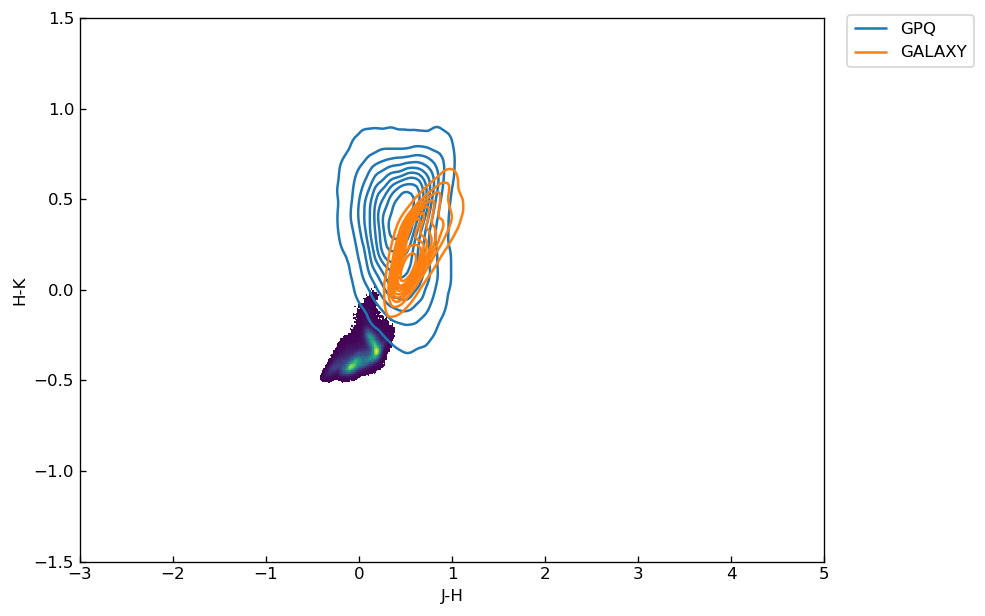

In [58]:
import mpl_scatter_density # adds projection='scatter_density'
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

# "Viridis-like" colormap with white background
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, '#440053'),
    (0.2, '#404388'),
    (0.4, '#2a788e'),
    (0.6, '#21a784'),
    (0.8, '#78d151'),
    (1, '#fde624'),
], N=256)


# plot kde density
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
sns.kdeplot(data=gpq, x="jh", y="hk",label='GPQ')
sns.kdeplot(data=galaxy, x="jh", y="hk", label='GALAXY')

ax.scatter_density(star['jh'],star['hk'],
            cmap=white_viridis)
#fig.colorbar(density, label='Number of points per pixel')
ax.legend(bbox_to_anchor=(1.02, 1.02), loc='upper left')

plt.xlim(-3,5)
plt.ylim(-1.5,1.5)
plt.xlabel('J-H')
plt.ylabel('H-K')
plt.savefig('trainingset_jhk_color')

/cargo/nhome/xingjian/.local/lib/python3.8/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/cargo/nhome/xingjian/.local/lib/python3.8/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


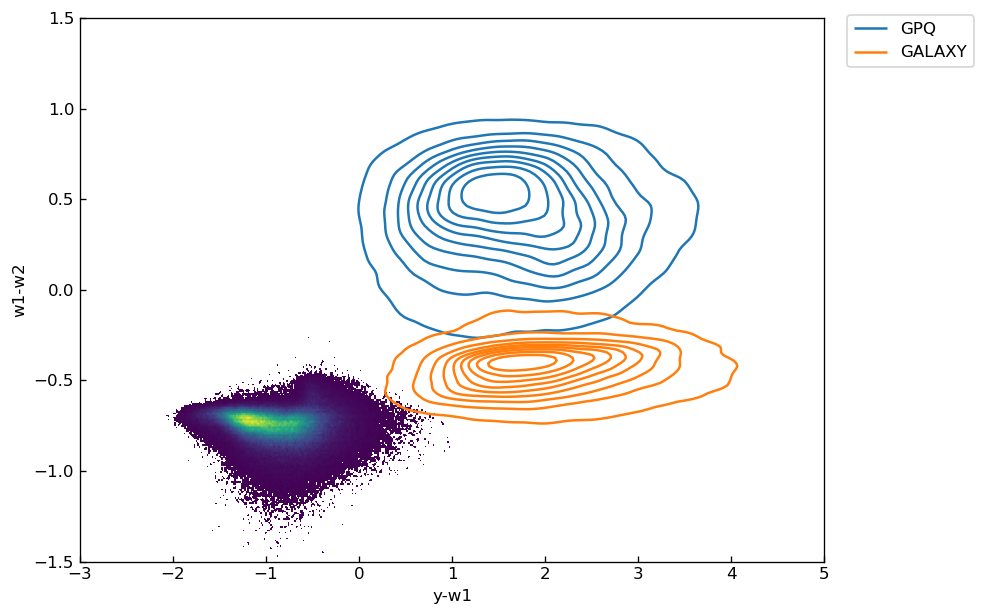

In [29]:
import mpl_scatter_density # adds projection='scatter_density'
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

# "Viridis-like" colormap with white background
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, '#440053'),
    (0.2, '#404388'),
    (0.4, '#2a788e'),
    (0.6, '#21a784'),
    (0.8, '#78d151'),
    (1, '#fde624'),
], N=256)


# plot kde density
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
sns.kdeplot(data=gpq, x="yw1", y="w1w2",label='GPQ')
sns.kdeplot(data=galaxy, x="yw1", y="w1w2", label='GALAXY')

ax.scatter_density(star['yw1'],star['w1w2'],
            cmap=white_viridis)
#fig.colorbar(density, label='Number of points per pixel')
ax.legend(bbox_to_anchor=(1.02, 1.02), loc='upper left')

plt.xlim(-3,5)
plt.ylim(-1.5,1.5)
plt.xlabel('y-w1')
plt.ylabel('w1-w2')
plt.savefig('trainingset')

In [49]:
features_name = ['i-z','z-y','y-j','j-h','h-k','i-w1','z-w1','y-w1','j-w1','h-w1','k-w1','w1-w2']

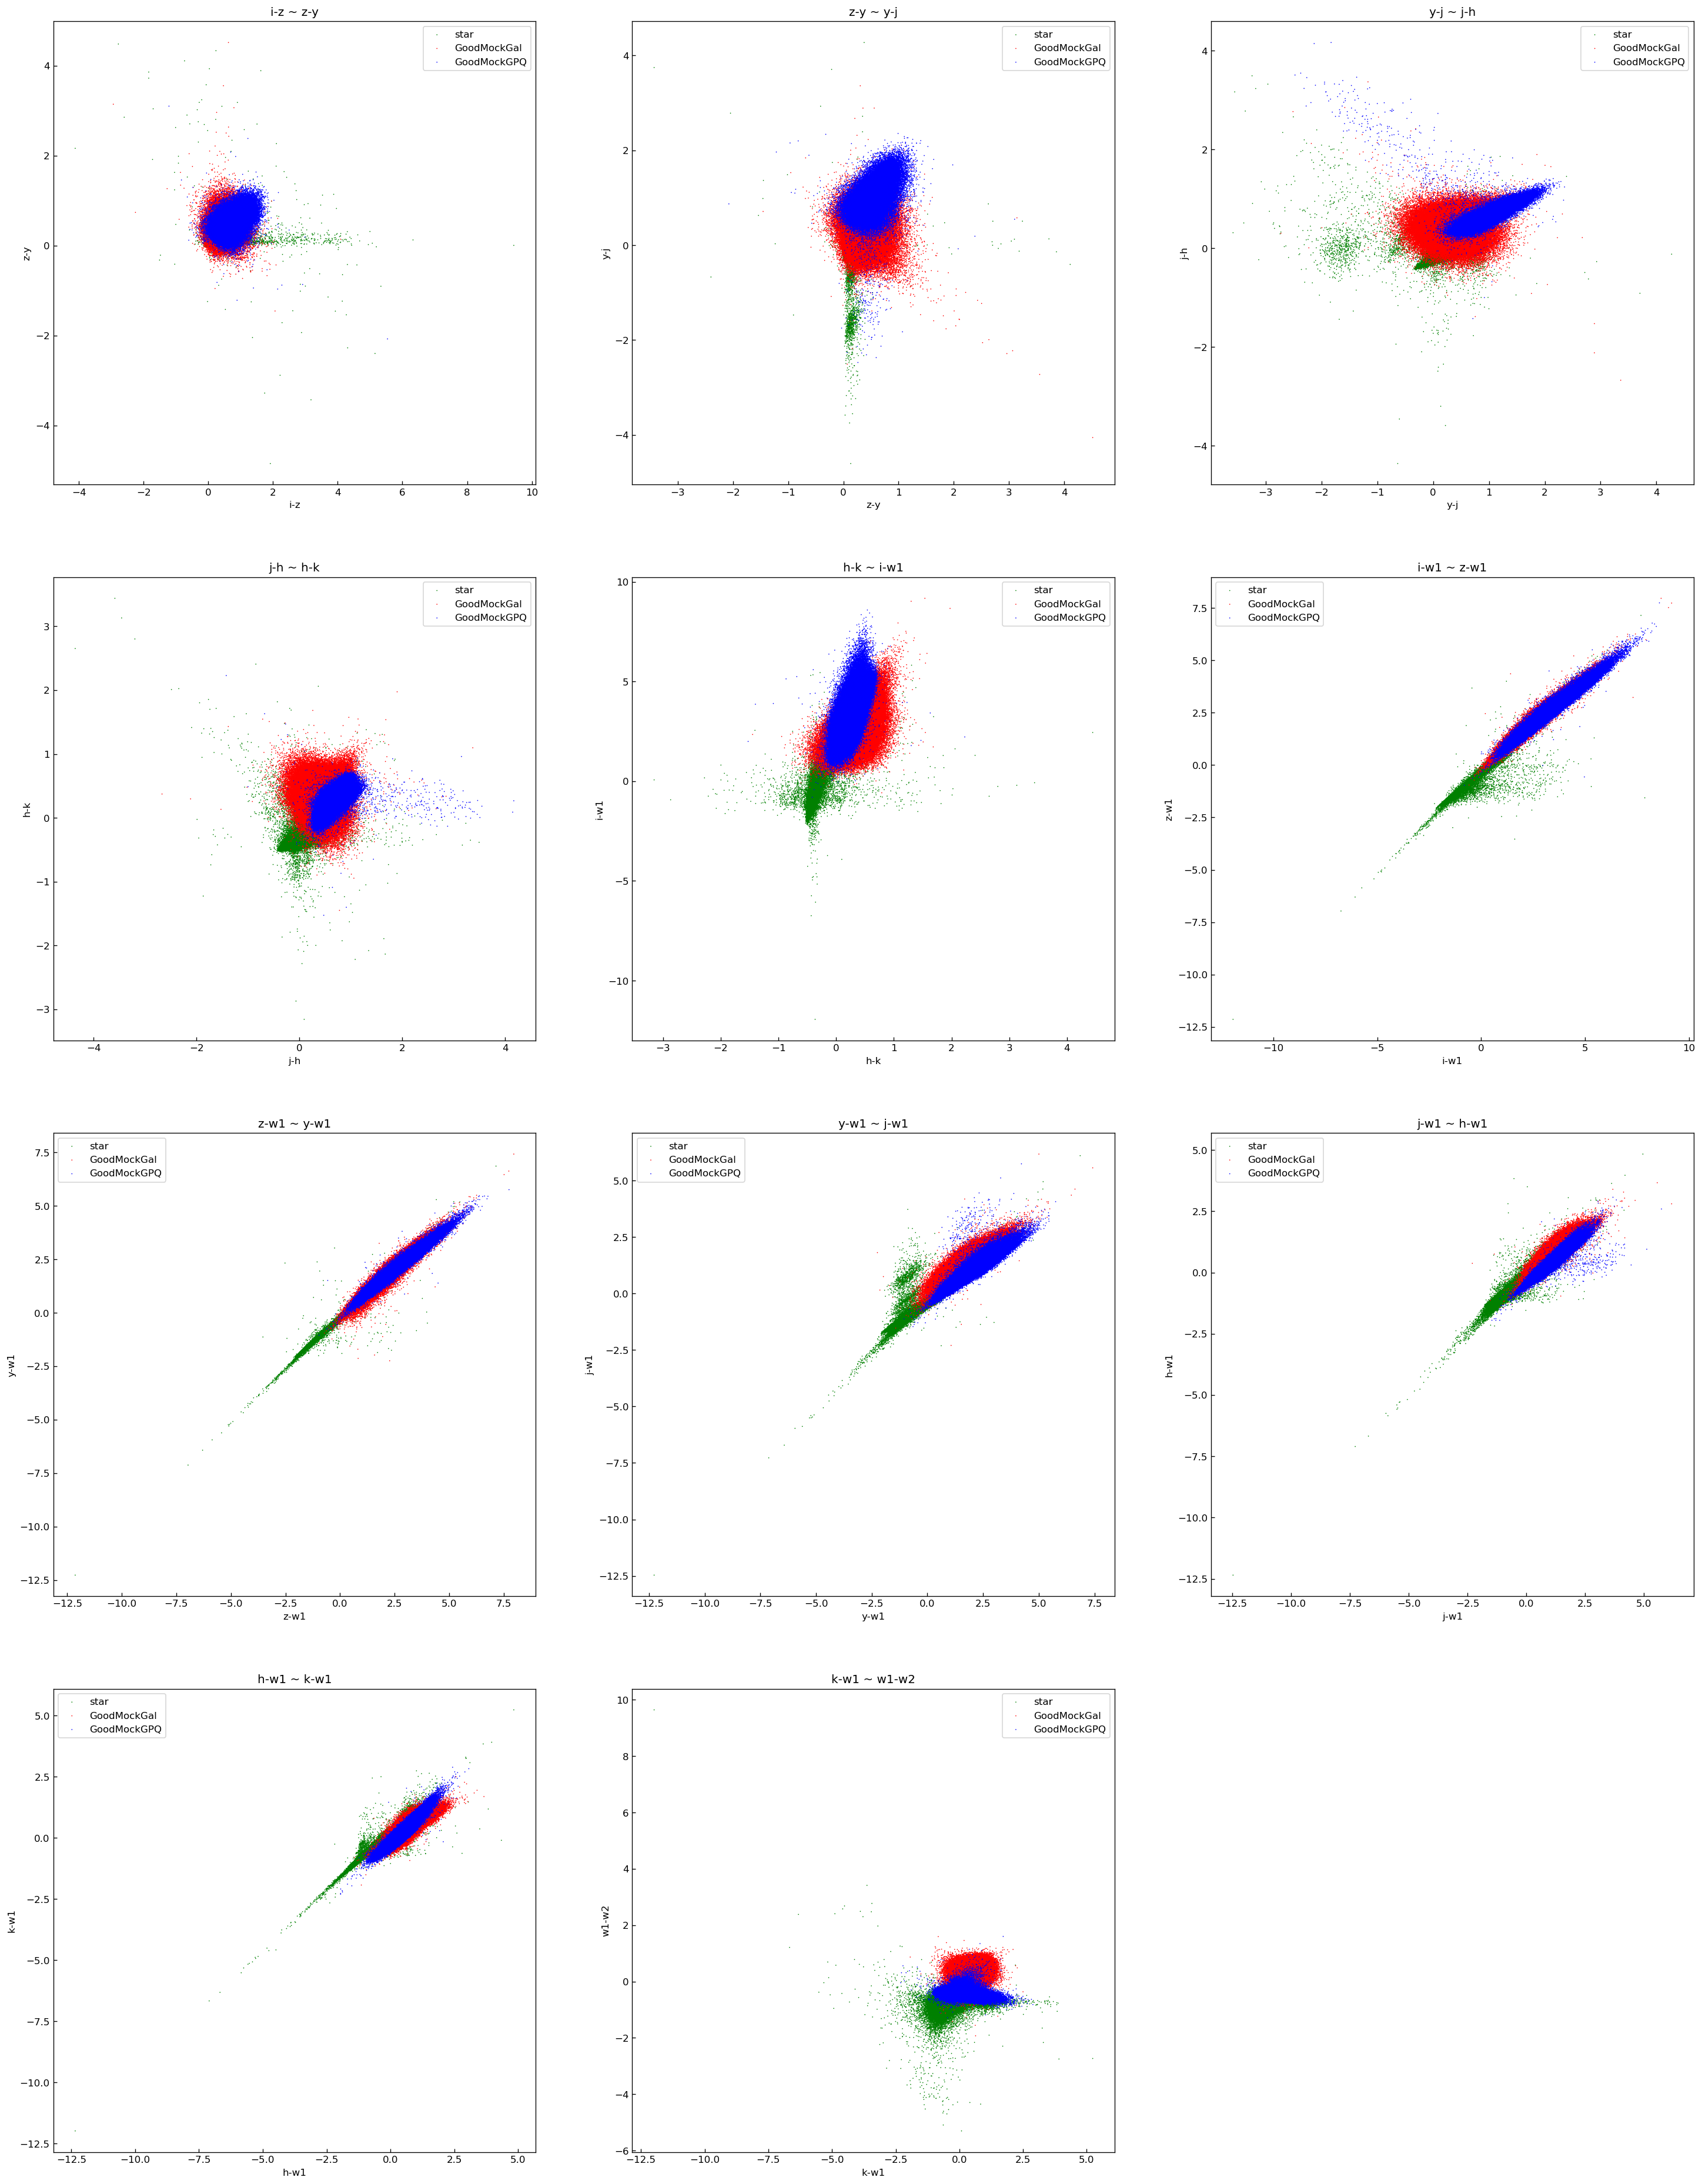

In [54]:
plt.figure(figsize=(30,40))

for i in range(11):
    plt.subplot(4, 3, i+1)
    plt.scatter(star[features[i]],star[features[i+1]],
                c='g',s=1,edgecolor='none',label='star',)
    plt.scatter(gpq[features[i]],gpq[features[i+1]],
                c='r',s=1,edgecolor='none',label='GoodMockGal',)
    plt.scatter(galaxy[features[i]],galaxy[features[i+1]],
                c='b',s=1,edgecolor='none',label='GoodMockGPQ')
    
 
    plt.xlabel(features_name[i])
    plt.ylabel(features_name[i+1])
    plt.legend()
    plt.title(features_name[i]+' ~ '+features_name[i+1])
    plt.savefig('trainingset-allcolors')

Text(0.5, 1.0, 'w1w2 - yw1 -- trainingset')

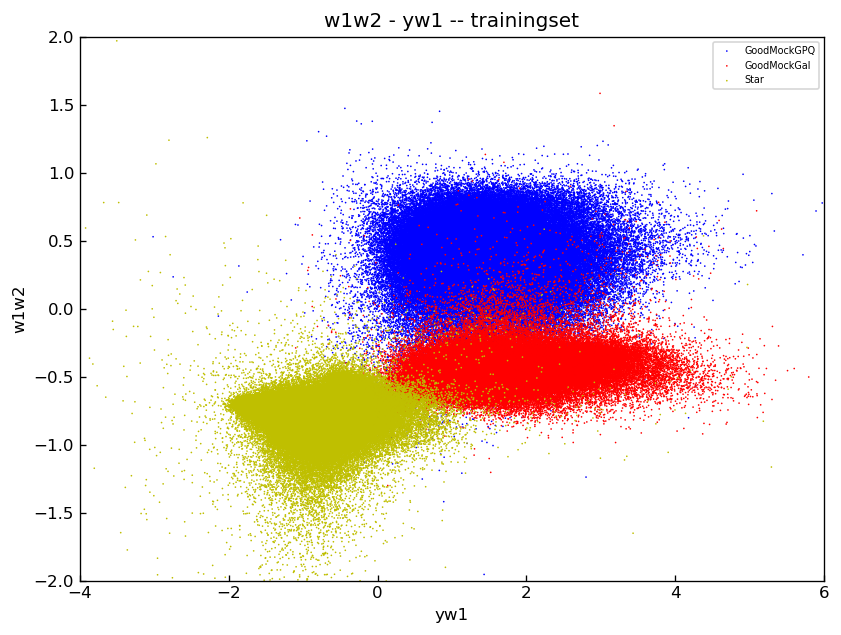

In [33]:
plt.scatter(gpq['yw1'],gpq['w1w2'],
                c='b',s=1,edgecolor='none',label='GoodMockGPQ')
plt.scatter(galaxy['yw1'],galaxy['w1w2'],
            c='r',s=1,edgecolor='none',label='GoodMockGal',)
plt.scatter(star['yw1'],star['w1w2'],
            c='y',s=1,edgecolor='none',label='Star',)


# plt.xticks([])
# plt.yticks([])
plt.xlim(-4,6)
plt.ylim(-2,2)
plt.xlabel('yw1')
plt.ylabel('w1w2')
plt.legend(fontsize='xx-small')
plt.title('w1w2 - yw1 -- trainingset')

/cargo/nhome/xingjian/.local/lib/python3.8/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/cargo/nhome/xingjian/.local/lib/python3.8/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)
/cargo/nhome/xingjian/.local/lib/python3.8/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/cargo/nhome/xingjian/.local/lib/python3.8/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)
/cargo/nhome/xingjian/.local/lib/python3.8/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/cargo/nhome/xingjian/.local/lib/python3.8/site-packages/mpl_scatter_density/gen

<Figure size 3600x1200 with 0 Axes>

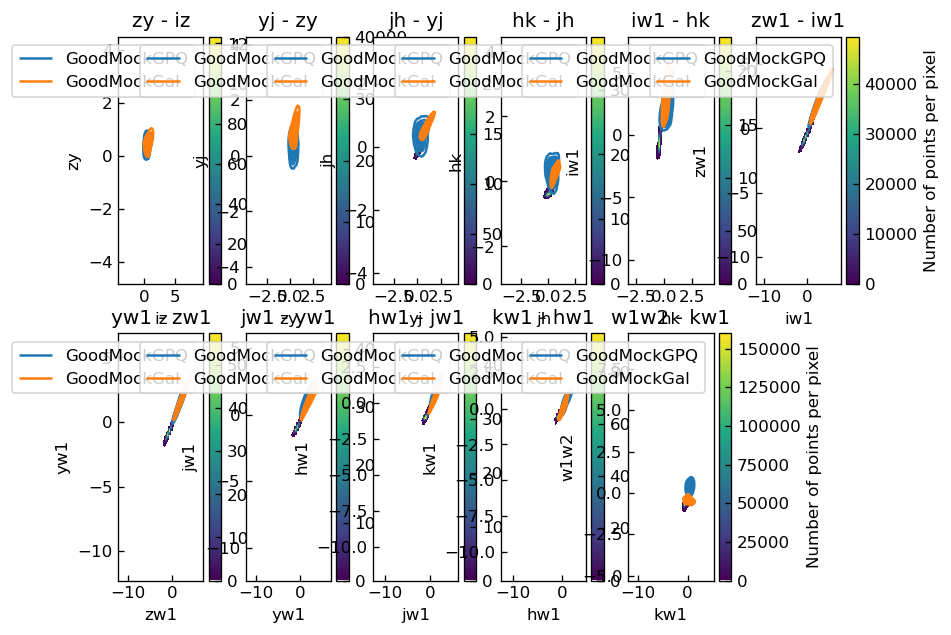

In [90]:
# plot color-color diagram

plt.figure(figsize=(30,10))
features = ['iz','zy','yj','jh','hk','iw1','zw1','yw1','jw1','hw1','kw1','w1w2']
fig = plt.figure()

for i in range(11):
    ax = fig.add_subplot(2, 6, i+1, projection='scatter_density')
    sns.kdeplot(data=gpq, x=features[i], y=features[i+1],label='GoodMockGPQ')
    sns.kdeplot(data=galaxy, x=features[i], y=features[i+1], label='GoodMockGal')

    density = ax.scatter_density(star[features[i]],star[features[i+1]],
            cmap=white_viridis)
    fig.colorbar(density, label='Number of points per pixel')
    ax.legend(bbox_to_anchor=(1.02, 1.02), loc='upper left')

    plt.xlabel(features[i])
    plt.ylabel(features[i+1])
    plt.legend()
    plt.title(features[i+1]+' - '+features[i])
    